In [1]:
#!pip install -e ../Maccabee > /dev/null

In [2]:
# !rm -rf _maccabee_compiled_code/

In [3]:
%reload_ext autoreload
%autoreload 1

In [4]:
import sys
sys.path.append("../Evaluation")

%aimport evaluation

from evaluation.analysis import *
from evaluation.persistence import *
from evaluation.plotting import *

%aimport evaluation.analysis
%aimport evaluation.plotting
%aimport evaluation.persistence


In [5]:
from maccabee.data_analysis.data_metrics import AXES_AND_METRIC_NAMES
from maccabee.constants import Constants
import maccabee.data_sources as data_sources
from maccabee.parameters import build_default_parameters

from maccabee.data_generation import DataGeneratingProcess, SampledDataGeneratingProcess, data_generating_method
from maccabee.data_generation.utils import evaluate_expression, CompiledExpression
# benchmarks
from maccabee.benchmarking import benchmark_model_using_concrete_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp_grid

# genmatch
from maccabee.examples.genmatch import GenmatchDataGeneratingProcess, build_genmatch_datasource, GENMATCH_SPECS
from maccabee.examples.genmatch import LogisticPropensityMatchingCausalModel
from maccabee.examples.genmatch import GENMATCH_BINARY_COVAR_INDECES

In [6]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn'])

import scipy.stats as st
import sympy as sp

In [7]:
COMPARISON_BENCHMARK = "G"

In [8]:
BASE_GENMATCH_DGP_PARAMS = {
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "TREATMENT_EFFECT_HETEROGENEITY": 0,
  "ACTUAL_CONFOUNDER_ALIGNMENT": 0,
  "TARGET_PROPENSITY_SCORE": 0.5,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}

A_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
A_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}
A_param_overrides["ACTUAL_CONFOUNDER_ALIGNMENT"] = 0.285
  
C_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
C_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.3,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}
C_param_overrides["ACTUAL_CONFOUNDER_ALIGNMENT"] = -1

G_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
G_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.75,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.22,
    "INTERACTION_THREE_WAY": 0,
}
G_param_overrides["ACTUAL_CONFOUNDER_ALIGNMENT"] = 0.15

GENMATCH_PARAM_OVERRIDES = {
    "A": A_param_overrides,
    "C": C_param_overrides,
    "G": G_param_overrides,
}

In [9]:
# Define axes and metrics to analyze
DATA_METRICS_SPEC = {
    Constants.AxisNames.OUTCOME_NONLINEARITY: [
        "Lin r2(X_obs, Y)",
#         "Lin r2(X_true, Y)"
    ],
    Constants.AxisNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)",
#         "Lin r2(X_true, Treat Logit)",
#         "Log r2(X_obs, T)"
    ],
    Constants.AxisNames.PERCENT_TREATED: [
        "Percent(T==1)"
    ],
#     Constants.AxisNames.BALANCE: [
#         "Wass dist X_true: T=1<->T=0",
#     ],
    Constants.AxisNames.ALIGNMENT: [
#         "Lin r2(Y, Treat Logit)", # here
#         "Lin r2(Y0, Treat Logit)"
    ],
#     Constants.AxisNames.TE_HETEROGENEITY: [
#         "std(TE)/std(Y)"
#     ]
}

In [10]:
N_CORES = 7
N_THREADS = 1

## Run MC Benchmarks

In [11]:
 %%time

CONCRETE_IN_ANALYSIS_MODE = True
CONCRETE_CACHED = False
CONCRETE_RESULT_BASENAME = f"concrete_{COMPARISON_BENCHMARK}"

if not CONCRETE_CACHED:
    # Concrete Genmatch Benchmark
    dgp = GenmatchDataGeneratingProcess(
        dgp_label=COMPARISON_BENCHMARK,
        n_observations=1000,
        data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE)

    concrete_result = benchmark_model_using_concrete_dgp(
            dgp=dgp,
            model_class=LogisticPropensityMatchingCausalModel,
            estimand=Constants.Model.ATT_ESTIMAND,
            num_sampling_runs_per_dgp=10,
            num_samples_from_dgp=10,
            data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE,
            data_metrics_spec=DATA_METRICS_SPEC,
            n_jobs=N_CORES,
            n_threads=N_THREADS)
    
    persist_result(CONCRETE_RESULT_BASENAME,concrete_result)
else:
    concrete_result = read_result(CONCRETE_RESULT_BASENAME)

concrete_perf_agg, concrete_perf_raw, concrete_data_agg, concrete_data_raw = \
    concrete_result


CPU times: user 977 ms, sys: 2.68 s, total: 3.65 s
Wall time: 8.93 s


In [13]:
from maccabee.data_generation.utils import evaluate_expression

DGPVariables = Constants.DGPVariables

SAMPLED_DYNAMIC = True
SAMPLED_OUTCOME_BIAS = True
DGPVariables.NORMALIZE_SAMPLED_OUTCOME_FUNCTION = False
DGPVariables.NORMALIZE_SAMPLED_TREATMENT_FUNCTION = True

# Sampled Genmatch Benchmark
class GenmatchLikeSampledDataGeneratingProcess(SampledDataGeneratingProcess):
    def __init__(self, *args, **kwargs):
        compile_functions = kwargs.pop("compile_functions")
        kwargs["compile_functions"] = False
        
        super().__init__(*args, **kwargs)
        if SAMPLED_OUTCOME_BIAS:
            self.bias = -3.85
            np.append(self.outcome_covariate_transforms, self.bias)
            self.untreated_outcome_subfunction += self.bias
            self.outcome_function += self.bias
            
        if compile_functions:
            symbols = sp.symbols(list(self.observed_covariate_data.columns))
            self.untreated_outcome_subfunction = \
                CompiledExpression(self.untreated_outcome_subfunction, symbols)
            self.treatment_assignment_function = \
                CompiledExpression(self.treatment_assignment_function, symbols)

    @data_generating_method(DGPVariables.OUTCOME_NOISE_NAME, [])
    def _generate_outcome_noise_samples(self, input_vars):
        return 0
    
    @data_generating_method(DGPVariables.TREATMENT_EFFECT_NAME, [])
    def _generate_treatment_effects(self, input_vars):
        return -0.4
    
    # dynamic dataset generation.
    @data_generating_method(DGPVariables.COVARIATES_NAME, [])
    def _generate_observed_covars(self, input_vars):
        if SAMPLED_DYNAMIC:
            return self.data_source.get_covar_df() 
        else:
            return self.observed_covariate_data
    
    @data_generating_method(
        DGPVariables.POTENTIAL_OUTCOME_WITHOUT_TREATMENT_NAME,
        [DGPVariables.COVARIATES_NAME],
        cache_result=(not SAMPLED_DYNAMIC))
    def _generate_outcomes_without_treatment(self, input_vars):
        observed_covariate_data = input_vars[DGPVariables.COVARIATES_NAME]
        return evaluate_expression(
            self.untreated_outcome_subfunction,
            observed_covariate_data) 

    @data_generating_method(
        DGPVariables.TREATMENT_EFFECT_NAME,
        [DGPVariables.COVARIATES_NAME],
        cache_result=(not SAMPLED_DYNAMIC))
    def _generate_treatment_effects(self, input_vars):
        observed_covariate_data = input_vars[DGPVariables.COVARIATES_NAME]
        return evaluate_expression(
            self.treatment_effect_subfunction,
            observed_covariate_data)

    @data_generating_method(
        DGPVariables.POTENTIAL_OUTCOME_WITH_TREATMENT_NAME,
        [
            DGPVariables.POTENTIAL_OUTCOME_WITHOUT_TREATMENT_NAME,
            DGPVariables.TREATMENT_EFFECT_NAME
        ],
        cache_result=(not SAMPLED_DYNAMIC))
    def _generate_outcomes_with_treatment(self, input_vars):
        outcome_without_treatment = input_vars[DGPVariables.POTENTIAL_OUTCOME_WITHOUT_TREATMENT_NAME]
        treatment_effect = input_vars[DGPVariables.TREATMENT_EFFECT_NAME]
        return outcome_without_treatment + treatment_effect

In [14]:
%%time

SAMPLED_IN_ANALYSIS_MODE = True
SAMPLED_CACHED = False
SAMPLED_RESULT_BASENAME = f"sampled_{COMPARISON_BENCHMARK}"

QUICK_EVAL = {
    "num_dgp_samples": 2,
    "num_sampling_runs_per_dgp": 2,
    "num_samples_from_dgp": 10,
    "dgp_kwargs": {
        "data_analysis_mode": SAMPLED_IN_ANALYSIS_MODE,
        "compile_functions": False
    },
}

SOLID_EVAL = {
    "num_dgp_samples": 50,
    "num_sampling_runs_per_dgp": 10,
    "num_samples_from_dgp": 200,
    "dgp_kwargs": {
        "data_analysis_mode": SAMPLED_IN_ANALYSIS_MODE,
        "compile_functions": True
    },
}

param_overrides = GENMATCH_PARAM_OVERRIDES[COMPARISON_BENCHMARK]

if not SAMPLED_CACHED:
    dgp_params = build_default_parameters()
    dgp_params.set_parameters(param_overrides)

    sampled_result = \
        benchmark_model_using_sampled_dgp(
            dgp_params, build_genmatch_datasource(),
            dgp_class=GenmatchLikeSampledDataGeneratingProcess,
            model_class=LogisticPropensityMatchingCausalModel,
            estimand=Constants.Model.ATE_ESTIMAND,
            data_analysis_mode=SAMPLED_IN_ANALYSIS_MODE,
            data_metrics_spec=DATA_METRICS_SPEC,
            n_jobs=40,#N_CORES,
            n_threads=N_THREADS,
            **QUICK_EVAL)

    persist_result(SAMPLED_RESULT_BASENAME, sampled_result)
else:
    sampled_result = read_result(SAMPLED_RESULT_BASENAME)
    
(
    sampled_perf_agg, sampled_perf_raw,
    sampled_perf_run_raw, sampled_data_agg,
    sampled_data_raw, dgps
) = sampled_result

Reducing alignment from 0.208 to 0.15
Reducing alignment from 0.208 to 0.15
Starting sampling for DGP 1/2
Starting sampling for DGP 2/2
CPU times: user 1.88 s, sys: 2.95 s, total: 4.83 s
Wall time: 8.65 s


### Data Metrics

In [15]:
if SAMPLED_IN_ANALYSIS_MODE and CONCRETE_IN_ANALYSIS_MODE:
    display_data_metrics_comparison(DATA_METRICS_SPEC,
                                    concrete_data_agg, sampled_data_agg)
#     for axes, metrics in DATA_METRICS_SPEC.items():
#         print(axes)
#         for metric in metrics:
#             print("\t", metric)

#             key = f"{axes} {metric}"
#             print("\t\tConcrete:", np.round(concrete_data_agg[key], 3))
#             print("\t\tSampled:", np.round(sampled_data_agg[key], 3))
    
#     for name, vals in sampled_data_raw.items():
#         if name.startswith("TREATMENT_NONLINEARITY"):
#             print(name, vals)

OUTCOME_NONLINEARITY
TREATMENT_NONLINEARITY
	 Lin r2(X_obs, Treat Logit)
	 - Concrete: 0.789
	 - Sampled: 0.194
PERCENT_TREATED
ALIGNMENT


### Performance Metrics

#### Concrete Performance

In [16]:
display_aggregated_performance_metrics(concrete_perf_agg)

AMBP: 17.192
AMBP (std): 6.216
RMSE: 0.112
RMSE (std): 0.019


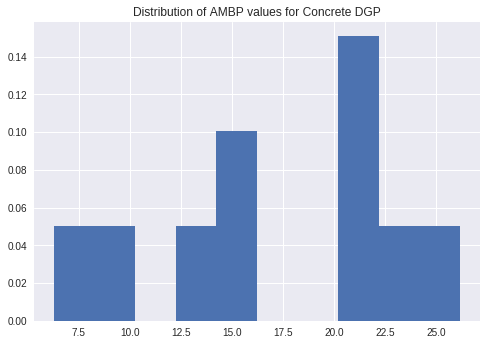

In [17]:
display_raw_performance_metrics(concrete_perf_raw, "AMBP", "Concrete DGP")

#### Sampled Performance

In [18]:
display_aggregated_performance_metrics(sampled_perf_agg)

AMBP: 1.146
AMBP (std): 0.486
RMSE: 0.068
RMSE (std): 0.018


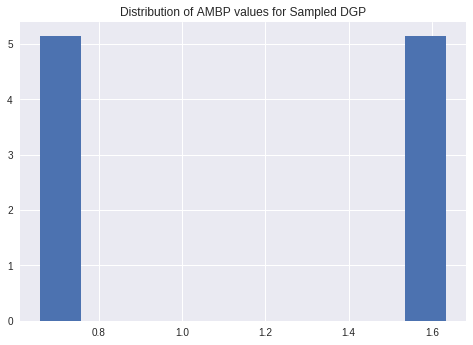

In [19]:
display_raw_performance_metrics(sampled_perf_raw, "AMBP", "Sampled DGP")

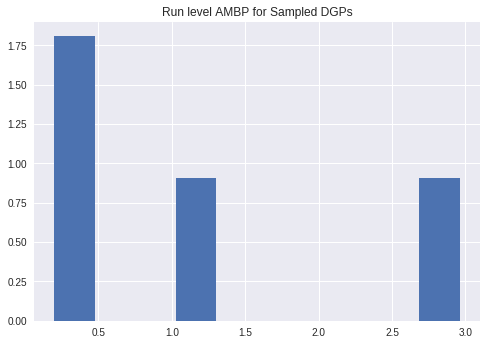

In [20]:
all_sampled_runs = [item for sublist in sampled_perf_run_raw["AMBP"] for item in sublist]
display_distro(all_sampled_runs, "Run level AMBP for Sampled DGPs")

#### Side by Side Comparison

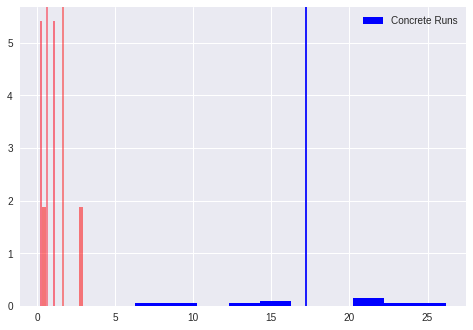

In [21]:
display_sampled_dgps_vs_concrete(sampled_perf_run_raw, concrete_perf_raw, "AMBP")

### Analysis

In [22]:
predictive_metric = "TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"
performance_metric = "AMBP"
performance_metric_outlier_lim = 10
metric_domain = np.linspace(0.1, 0.95, 100)

In [23]:
sampled_metric_vals = np.array(sampled_data_raw[predictive_metric])
sampled_perf_vals = np.array(sampled_perf_raw[performance_metric])
sampled_perf_run_vals = np.array(sampled_perf_run_raw[performance_metric])

outlier_locs = sampled_perf_vals > performance_metric_outlier_lim
num_outliers = np.sum(outlier_locs)
print(f"Removing {num_outliers} outliers. {performance_metric}s: {sampled_perf_vals[outlier_locs]}")
outlier_filter = sampled_perf_vals < performance_metric_outlier_lim

sampled_metric_vals = sampled_metric_vals[outlier_filter]
sampled_perf_vals = sampled_perf_vals[outlier_filter]
sampled_perf_run_vals = sampled_perf_run_vals[outlier_filter, :]

concrete_metric_vals = np.array(concrete_data_raw[predictive_metric])
concrete_perf_vals = np.array(concrete_perf_raw[performance_metric])


Removing 0 outliers. AMBPs: []


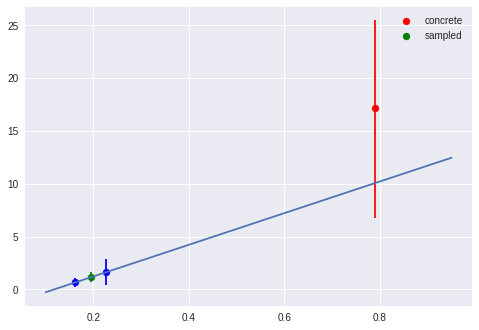

In [24]:
plot_dgp_metric_vs_perf(concrete_metric_vals, concrete_perf_vals,
                        "r", "concrete")

plot_dgp_metric_vs_perf(sampled_metric_vals, sampled_perf_vals,
                        "g", "sampled")

for sample_metric_val, sampled_dgp_runs in zip(sampled_metric_vals, sampled_perf_run_vals):
    plot_dgp_metric_vs_perf(sample_metric_val, sampled_dgp_runs, "b", None)

grad, intr, r, p, _ = st.linregress(sampled_metric_vals, sampled_perf_vals)
plt.plot(metric_domain, grad*metric_domain + intr)
plt.legend()
plt.show()
# grad, intr, r, p, _, sampled_perf_raw["AMBP"]

In [27]:

category_data = get_term_category_data(dgps)

categories = [
    Constants.DGPSampling.INTERACTION_TWO_WAY,
    Constants.DGPSampling.POLY_QUADRATIC,
    Constants.DGPSampling.LINEAR,
]

for category in categories:
    category_counts = list(map(lambda data: data[0][category], category_data))
    print(category, np.mean(category_counts), np.std(category_counts))

INTERACTION_TWO_WAY 12.0 0.0
POLY_QUAD 3.0 0.0
LINEAR 7.0 0.0


In [29]:
# Categorize the interaction terms in terms of presence 
# of binary covars as neither, one or both components
# for in each DGP
binary_data = []
for data in category_data:
    interactions = data[1][Constants.DGPSampling.INTERACTION_TWO_WAY]
    get_is_binary_statuses = lambda var_name: int(str(var_name)[1:]) in GENMATCH_BINARY_COVAR_INDECES
    
    interaction_binary_classes = [
        categorize_interaction_two_way([
            get_is_binary_statuses(interaction_var)
            for interaction_var in interaction_vars
        ])
        for interaction_vars in interactions
    ]
    
    binary_data.append(interaction_binary_classes)

binary_data = np.array(binary_data)
both_counts = np.sum(binary_data == "both", axis=1)
one_counts = np.sum(binary_data == "one", axis=1)

R^2 1.0 P 0.0


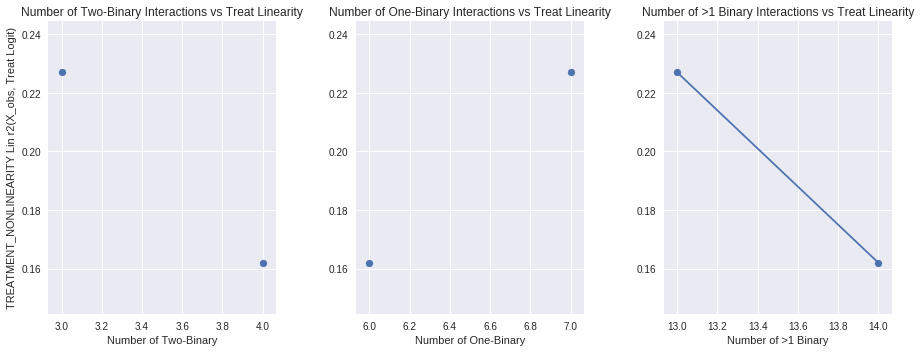

In [46]:
plt.figure(figsize=(13, 5))

plt.subplot(131)
plt.title("Number of Two-Binary Interactions vs Treat Linearity")
plt.ylabel(predictive_metric)
plt.xlabel("Number of Two-Binary")
plt.scatter(both_counts, sampled_metric_vals)

plt.subplot(132)
plt.title("Number of One-Binary Interactions vs Treat Linearity")
plt.xlabel("Number of One-Binary")
plt.scatter(one_counts, sampled_metric_vals)

plt.subplot(133)
plt.title("Number of >1 Binary Interactions vs Treat Linearity")
plt.xlabel("Number of >1 Binary")
aggregated_binary_counts = 2*both_counts + one_counts
plt.scatter(aggregated_binary_counts, sampled_metric_vals)

# regression plot
slope, intr, r_value, p_value, _ = st.linregress(
   aggregated_binary_counts, sampled_metric_vals)
plt.plot(aggregated_binary_counts, slope*aggregated_binary_counts + intr)

print("R^2", r_value**2, "P", p_value)
plt.tight_layout()
plt.show()

# The choice of binary interactions matters for the metric (which we know)
# is correlated with the performance of the estimator.

R^2 1.0 P 0.0


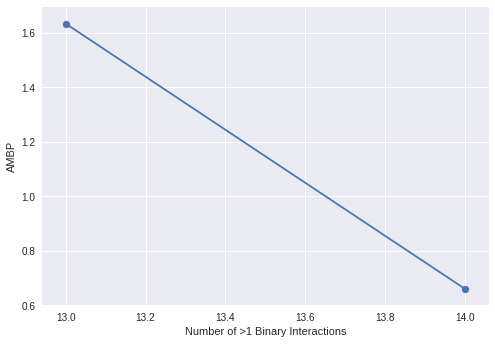

In [48]:
plt.scatter(aggregated_binary_counts, sampled_perf_vals)
plt.xlabel("Number of >1 Binary Interactions")
plt.ylabel(performance_metric)
# regression plot
slope, intercept, r_value, p_value, _ = st.linregress(aggregated_binary_counts, sampled_perf_vals)
plt.plot(agg_counts, slope*agg_counts + intercept)

print("R^2", r_value**2, "P", p_value)
plt.show()

# The choice of binary interactions matters for performance of the estimator.

## Narrative

Authors create a semi realistic data set - mix of binary and normal covariates.

The hand-select a set of functions with escalating levels of nonlinearity and non-additivity.

This analysis will show why this is a problematic strategy. Instead of tuning Maccabee to sample from specific location: sample functions which look very similar to their function in terms of expected structure.

Keep everything else constant: same data, same constant treatment effect, same lack of outcome noise, same coeff distro (by inspection) *TODO verify this distr via histogram*. *TODO: see what happens with non-dynamic datasets*.

This is a much lower variance setting than a standard maccabee sampler: normally would sample a wide class of functions with similar metrics. Here, we sample from the class of functions. Implication is that variance in this class is a subset of wider variance we would expect from the universe of possible functional forms could have selected.

The results show the following:
- We do indeed sample from universe of same structure functions. Ratio of components is identical.
- There is a wide distro over performance
- Digging into this, we see one contributing factor is a distro over the treatment assignment metric. **IE, identical structure** is producing highly varied non-linearity metrics.
- It could be that this metric is useless but we see that it is indeed strongly correlated with performance of the estimator. So the metric matters.

It appears the variance comes from different distro over binary variables in the interactions. This is logical given it is the only real difference.

**Key take-aways**

- Hand specified forms are a single sample from a (potentially wide) distribution over **realized** value of targeted distributional setting as proxied by values of metrics. And these distributional setting are correlated to performance (again, via metrics) (as is expected)

- This would be even wider if we sampled from a wider class of variables (*TODO relax the constrains by moving back to soft sampler and see what happens*)

- Even within a single metric setting, there is variance from other factors - both data set and other distributional setting values. This means that even with in a fixed target, there is a need for averaging.

- So to really test a method, must sample by targeting distributional metrics. In practice, this means average over many realizations with the correct - on average metric value. Any single is hard to find and may not capture range of other possible distributional settings. 

Put formally, we want the conditional marginal over a specific distributional setting.



In [ ]:
# TRUE_TREAT_LOGIT = dgp.treatment_logit_expression

# class GenmatchEquivDataGeneratingProcess(SampledDataGeneratingProcess):
#     @data_generating_method(Constants.DGPVariables.OUTCOME_NOISE_NAME, [])
#     def _generate_outcome_noise_samples(self, input_vars):
#         return 0
    
#     @data_generating_method(Constants.DGPVariables.TREATMENT_EFFECT_NAME, [])
#     def _generate_treatment_effects(self, input_vars):
#         return -0.4
    
#     @data_generating_method(Constants.DGPVariables.PROPENSITY_SCORE_NAME,
#                             [Constants.DGPVariables.COVARIATES_NAME])
#     def _generate_true_propensity_scores(self, input_vars):
#         observed_covariate_data = input_vars[Constants.DGPVariables.COVARIATES_NAME]

#         logits = evaluate_expression(
#             TRUE_TREAT_LOGIT,
#             observed_covariate_data)

#         return 1/(1 + np.exp(-1*logits))